In [56]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [1]:
import numpy as np
import tensorflow as tf
from keras import datasets, models, layers 
import time
from matplotlib import pyplot as plt

In [2]:
(X_train, _), (X_test, _ ) = datasets.mnist.load_data()

In [3]:
X_train.shape
X_test.shape

(10000, 28, 28)

In [4]:
def subplt (rows, cols, img):
  plt_img = img[:rows*cols]
  for i in range(len(plt_img)):
    plt.subplot(rows, cols, i+1)
    plt.imshow(plt_img[i], cmap = 'gray')
    plt.axis('off')
  
  return

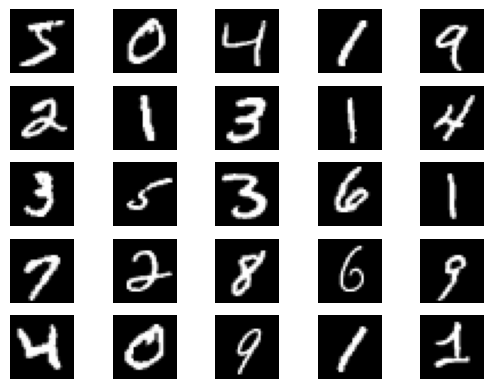

In [5]:
subplt(5,5,X_train)

In [6]:
X_train.max()

255

In [7]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [8]:
# Creating Noisy data
noise_fac = 0.2

X_train_noise = X_train + noise_fac * np.random.normal(loc = 0, scale = 1.0, size = X_train.shape)
X_test_noise = X_test + noise_fac * np.random.normal(loc = 0, scale = 1.0, size = X_test.shape)                                                     

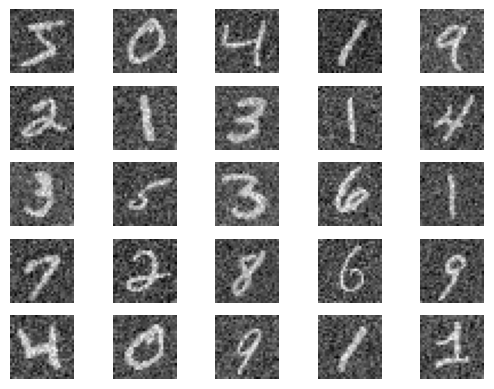

In [27]:
subplt(5,5,X_train_noise)

In [10]:
X_train = X_train.reshape(X_train.shape[0],28,28,1)
X_test = X_test.reshape(X_test.shape[0],28,28,1)
X_train_noise = X_train_noise.reshape(X_train_noise.shape[0],28,28,1)
X_test_noise = X_test_noise.reshape(X_test_noise.shape[0],28,28,1)

## Creating Autoencoder Model

In [11]:
input_layer = layers.Input(shape = (28,28,1), name = 'Input_Layer')

#encoder
x = layers.Conv2D(filters = 8,
                  kernel_size = (3,3),
                  strides = (1,1),
                  padding = 'same',
                  activation = 'relu',
                  use_bias = False,
                  kernel_initializer = 'he_uniform')(input_layer)
x = layers.MaxPool2D((2,2))(x)
x = layers.Conv2D(filters = 12,
                  kernel_size = (3,3),
                  strides = (1,1),
                  padding = 'same',
                  activation = 'relu',
                  use_bias = False,
                  kernel_initializer = 'he_uniform')(x)
x = layers.MaxPool2D((2,2))(x)
x = layers.Conv2D(filters = 16,
                  kernel_size = (3,3),
                  strides = (1,1),
                  padding = 'same',
                  activation = 'relu',
                  use_bias = False,
                  kernel_initializer = 'he_uniform')(x)
encoded_layer = layers.MaxPool2D((2,2), name = 'encoded_layer')(x)

#decoder
x = layers.Conv2DTranspose(filters = 16,
                  kernel_size = (3,3),
                  strides = (1,1),
                  padding = 'same',
                  activation = 'relu',
                  use_bias = False,
                  kernel_initializer = 'he_uniform')(encoded_layer)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(filters = 12,
                  kernel_size = (3,3),
                  strides = (1,1),
                  padding = 'same',
                  activation = 'relu',
                  use_bias = False,
                  kernel_initializer = 'he_uniform')(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(filters = 8,
                  kernel_size = (3,3),
                  strides = (1,1),
                  # padding = 'same',
                  activation = 'relu',
                  use_bias = False,
                  kernel_initializer = 'he_uniform')(x)
x = layers.UpSampling2D((2,2))(x)
decoded_layer = layers.Conv2DTranspose(filters = 1,
                  kernel_size = (3,3),
                  strides = (1,1),
                  padding = 'same',
                  activation = 'sigmoid',
                  use_bias = False,
                  kernel_initializer = 'he_uniform',
                  name = 'decoded_layer')(x)

In [12]:
dae = models.Model( inputs = input_layer, outputs = decoded_layer, name = 'denoising-ae')
dae.summary()

Model: "denoising-ae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 12)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 16)       │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded_layer (MaxPooling2D)    │ (None, 3, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 3, 3, 16)       │         2,304 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 6, 6, 12)       │         1,728 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 12, 12, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 14, 14, 8)      │           864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoded_layer (Conv2DTranspose) │ (None, 28, 28, 1)      │            72 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,632 (29.81 KB)

 Trainable params: 7,632 (29.81 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
dae.compile(optimizer = 'adam', loss = 'mse')


In [70]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os

checkpoint_path = "./checkpoints/DenoisingAutoencoder/ckpt-{epoch:04d}.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_freq='epoch', 
    verbose=1)

In [71]:
epochs = 50 
batch_size = 128

training = 1  # Set to 0 when resuming training

if training:
    start = time.time()
    history = dae.fit(
        x= X_train_noise, y = X_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[checkpoint_callback],
        validation_data = (X_test_noise,X_test), 
        verbose=1
    )
    print(f"Time consumed = {time.time()-start}")
    
# To resume training from the last checkpoint if training is set to 0
#training == 0
else:               
    start = time.time() 
                                    
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    initial_epoch = 50
    if latest_checkpoint:
        dae.load_weights(latest_checkpoint)
        print(f"Loaded model weights from {latest_checkpoint}")
        history = dae.fit(
        x=X_train_noise, y=X_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[checkpoint_callback],
        validation_data=(X_test_noise, X_test),
        initial_epoch=initial_epoch,
        verbose=1
)
    else:
        print("No checkpoint found, start training from scratch.")
    training = 1  # Reset training to 1 to continue the training process
    print(f"Time consumed = {time.time()-start}")


Epoch 1/50
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0938
Epoch 1: saving model to ./checkpoints/DenoisingAutoencoder/ckpt-0001.weights.h5
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0933 - val_loss: 0.0363
Epoch 2/50
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0337
Epoch 2: saving model to ./checkpoints/DenoisingAutoencoder/ckpt-0002.weights.h5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0337 - val_loss: 0.0269
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0262
Epoch 3: saving model to ./checkpoints/DenoisingAutoencoder/ckpt-0003.weights.h5
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0262 - val_loss: 0.0231
Epoch 4/50
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0224
Epoch 4: saving model to ./checkpoints/DenoisingAutoencoder/ckpt-0004.weights.h5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0224 - val_loss: 0.0200
Epoch 5/50
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0200
Epoch 5: saving model to ./check

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Loss (epochs=50, batch_size=128)')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

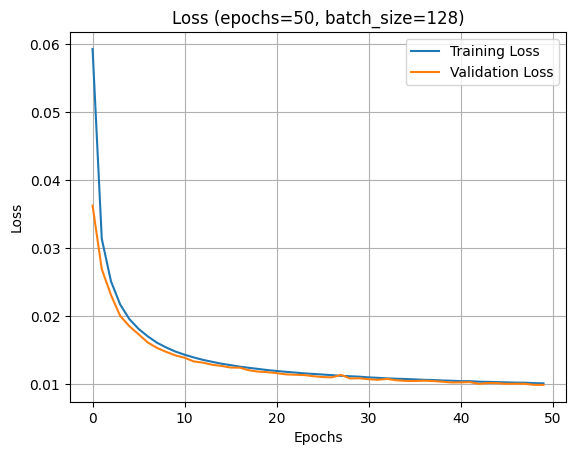

In [72]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f"Loss (epochs={epochs}, batch_size={batch_size})")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [96]:
dae.save("DenoisingAutoencoder-Mnist.h5")

In [20]:
dae.load_weights("checkpoints/DenoisingAutoencoder/ckpt-0050.weights.h5")

c:\Users\shory\anaconda3\envs\myenv\lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [14]:
encoder = models.Model(inputs = input_layer, outputs = encoded_layer)
encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 12)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 16)       │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded_layer (MaxPooling2D)    │ (None, 3, 3, 16)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,664 (10.41 KB)

 Trainable params: 2,664 (10.41 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
decoder = models.Model(inputs = encoded_layer, outputs = decoded_layer)
decoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_5CLONE             │ (None, 3, 3, 16)       │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 3, 3, 16)       │         2,304 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 6, 6, 12)       │         1,728 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 12, 12, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 14, 14, 8)      │           864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoded_layer (Conv2DTranspose) │ (None, 28, 28, 1)      │            72 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,968 (19.41 KB)

 Trainable params: 4,968 (19.41 KB)

 Non-trainable params: 0 (0.00 B)

## Testing model on testing data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


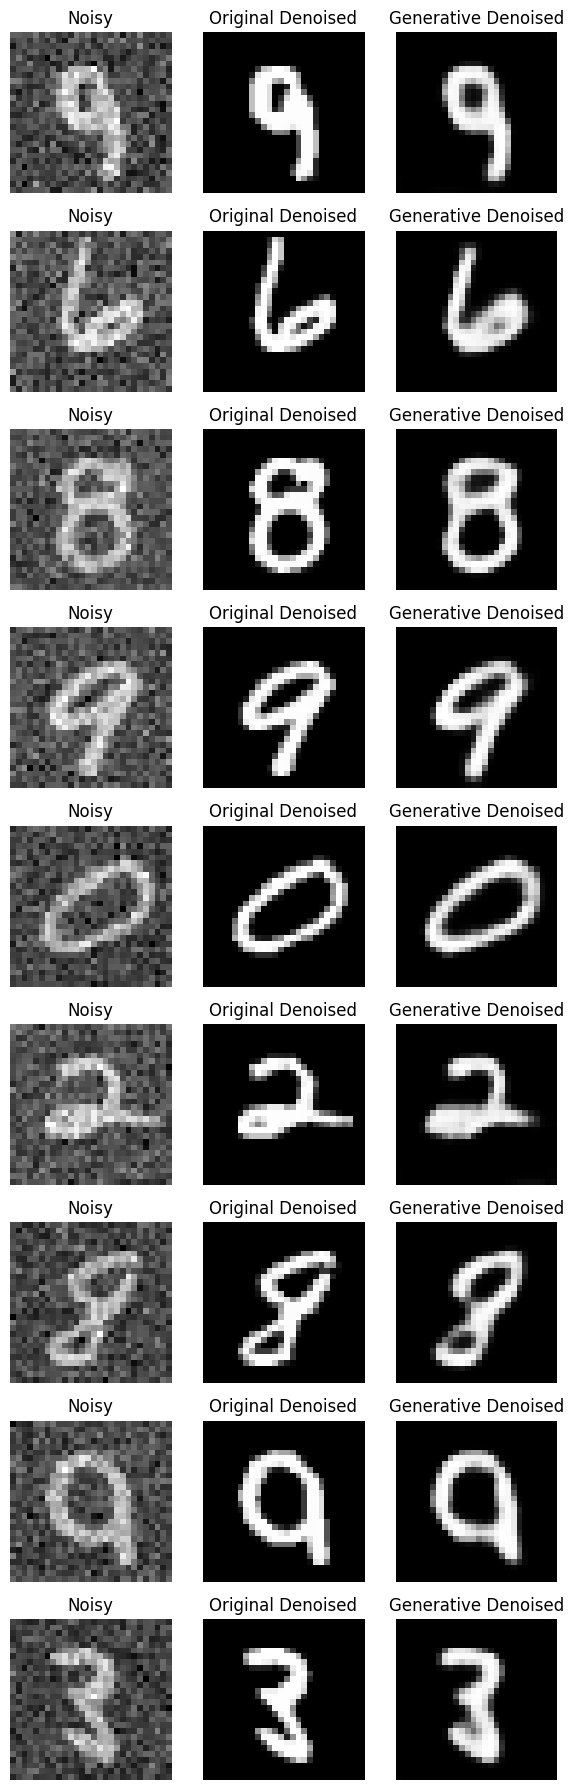

In [53]:
rows = 9
cols = 3

indices = np.random.randint(0, len(X_test_noise), rows)

test_noise_images = X_test_noise[indices]
test_images = X_test[indices]

encoded_imgs = encoder.predict(test_noise_images)
reconstructed_images = decoder.predict(encoded_imgs)

plt.figure(figsize=(cols*2, rows*2))

for i in range(len(indices)):
    # Noisy image
    plt.subplot(rows, cols, 3*i + 1)
    plt.imshow(test_noise_images[i].reshape(28, 28), cmap='gray')
    plt.title('Noisy')
    plt.axis('off')

    # Original denoised image
    plt.subplot(rows, cols, 3*i + 2)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title('Original Denoised')
    plt.axis('off')

    # Reconstructed image
    plt.subplot(rows, cols, 3*i + 3)
    plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    plt.title('Generative Denoised')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [58]:
from sklearn.metrics import mean_squared_error

test_noise = X_test_noise.reshape(X_test_noise.shape[0],-1)
test = X_test.reshape(X_test.shape[0],-1)

encoded = encoder.predict(X_test_noise)
pred = decoder.predict(encoded)
pred = pred.reshape(pred.shape[0],-1)

mse = mean_squared_error(test,pred)
print(f"mse = {mse}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
mse = 0.009893021930423705
